In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [2]:
IMG_DIM = 128

def imread(img_path):
    img = cv2.imread(img_path)
    img = img.astype('float32')/255.0
    img = cv2.resize(img, (IMG_DIM, IMG_DIM))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

In [3]:
pwd

'/kaggle/working'

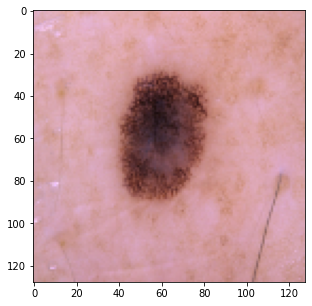

(128, 128, 3)

In [4]:
img_path = '../input/skin-cancer-malignant-vs-benign/train/benign/100.jpg'
img = imread(img_path)
imshow(img)
img.shape

In [5]:
def create_dataframe(data_path):
    class_dict = {
        'benign': 0,
        'malignant': 1
    }
    image_paths = []
    image_outputs = []
    for c, output in class_dict.items():
        folder_path = os.path.join(data_path, c)
        for f in os.listdir(folder_path):
            f_path = os.path.join(folder_path, f)
            if f_path.lower().endswith('.jpg'):
                image_paths.append(f_path)
                image_outputs.append(output)
    df = pd.DataFrame({
        'path': image_paths,
        'output': image_outputs
    })
    return df

In [6]:
DATA_PATH = '../input/skin-cancer-malignant-vs-benign'
train_df = create_dataframe(os.path.join(DATA_PATH, 'train'))
test_df = create_dataframe(os.path.join(DATA_PATH, 'test'))

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.33, random_state=0)

In [8]:
# X.shape = (n_images, img_height, img_width, channels)
# X.shape = (n_images, IMG_DIM, IMG_DIM, 3)

def read_images(img_paths):
    img_paths = list(img_paths)
    n = len(img_paths)
    X = np.zeros((n, IMG_DIM, IMG_DIM, 3), dtype='float32')
    for i in tqdm(range(n)):
        path = img_paths[i]
        img = imread(path)
        X[i] = img
    return X

In [9]:
X_train = read_images(train_df['path'])
X_val = read_images(val_df['path'])
X_test = read_images(test_df['path'])

y_train = train_df['output']
y_val = val_df['output']
y_test = test_df['output']

100%|██████████| 660/660 [00:04<00:00, 142.04it/s]


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Dense

In [11]:
model = Sequential()
model.add(Conv2D(16, 7, activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(16, 7, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(GlobalAvgPool2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() 

2022-12-02 12:33:42.943521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 122, 16)      2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 16)      12560     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        1

2022-12-02 12:33:42.944419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:43.125652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:43.126637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:43.127420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:43.128176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('saved-models/best.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=32,
    callbacks=[checkpoint],
)

2022-12-02 12:33:47.488951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120


2022-12-02 12:33:49.742275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 12s 43ms/step - loss: 0.6814 - accuracy: 0.5391 - val_loss: 0.6917 - val_accuracy: 0.5327

Epoch 00001: val_loss improved from inf to 0.69172, saving model to saved-models/best
Epoch 2/120
56/56 [==============================] - 1s 26ms/step - loss: 0.6883 - accuracy: 0.5527 - val_loss: 0.6892 - val_accuracy: 0.5350

Epoch 00002: val_loss improved from 0.69172 to 0.68918, saving model to saved-models/best
Epoch 3/120
56/56 [==============================] - 1s 26ms/step - loss: 0.6456 - accuracy: 0.6200 - val_loss: 0.5970 - val_accuracy: 0.7176

Epoch 00003: val_loss improved from 0.68918 to 0.59697, saving model to saved-models/best
Epoch 4/120
56/56 [==============================] - 1s 26ms/step - loss: 0.5996 - accuracy: 0.7005 - val_loss: 0.5863 - val_accuracy: 0.7268

Epoch 00004: val_loss improved from 0.59697 to 0.58627, saving model to saved-models/best
Epoch 5/120
56/56 [==============================] - 1s 26ms/step - loss: 0.5835 - 

In [13]:
hist_df = pd.DataFrame(history.history)

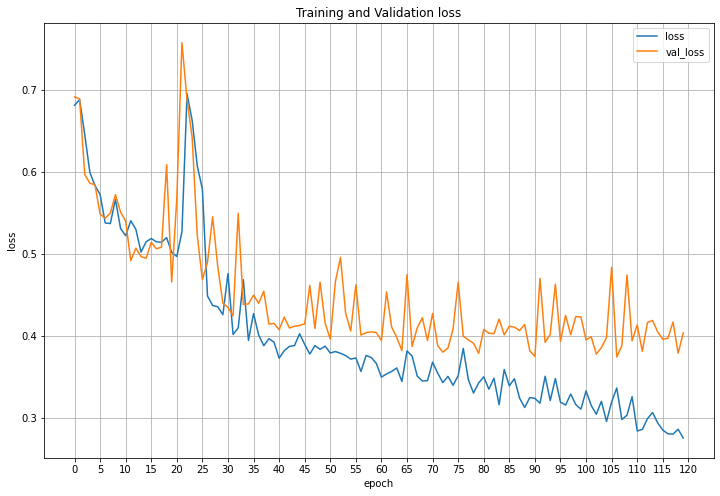

In [14]:
hist_df.plot(y=['loss', 'val_loss'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 5))
plt.show()

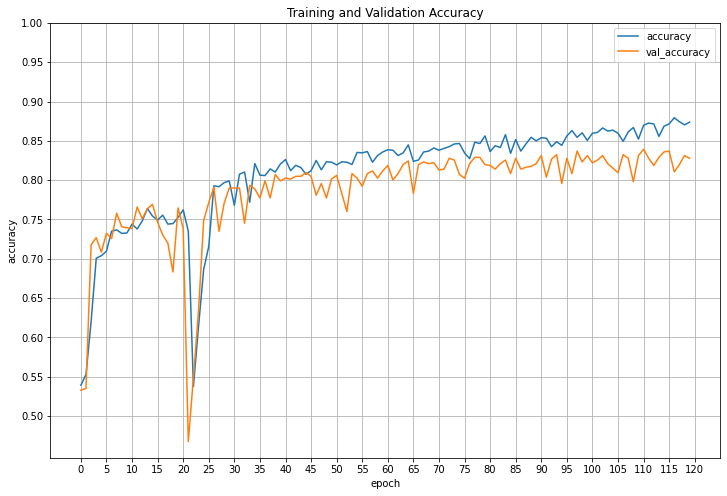

In [15]:
hist_df.plot(y=['accuracy', 'val_accuracy'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 5))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

In [16]:
model.load_weights('saved-models/best.h5')

In [17]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 20ms/step - loss: 0.3839 - accuracy: 0.8106


[0.3838511109352112, 0.810606062412262]

In [18]:
img = imread('../input/skin-cancer-malignant-vs-benign/test/malignant/1005.jpg')
img = np.expand_dims(img, 0)
y = model.predict(img)[0][0]
print(y)
if y > 0.5:
    print('Malignant')
else:
    print('Benign')

0.9734085
Malignant
